In [137]:
import numpy as np
from pandas import read_csv
import pandas_datareader.data as web

In [138]:
doge = web.DataReader('MONA-USD', 'yahoo')
doge

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-11-09,3.039360,2.840420,2.855220,2.967630,4630550,2.967630
2017-11-10,2.993850,2.606440,2.959770,2.616590,3069090,2.616590
2017-11-11,2.714720,2.520320,2.627440,2.597220,3258960,2.597220
2017-11-12,3.109670,2.173080,2.598040,2.817210,9822060,2.817210
2017-11-13,3.254420,2.666150,2.795100,2.895720,9818930,2.895720
...,...,...,...,...,...,...
2022-04-19,0.896073,0.883590,0.891385,0.889009,151928,0.889009
2022-04-20,0.898475,0.882716,0.889078,0.892699,192726,0.892699
2022-04-21,0.902868,0.879381,0.892625,0.881785,167541,0.881785


In [139]:
#lstm_data = np.genfromtxt('./sample_data/lstm.csv', delimiter=',', skip_header=True)
lstm_data = read_csv('lstmsmona.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close   Volume  Adj Close  Polarity Score
0   1.241455  1.182781  1.236694  1.184539  1251855   1.184539        0.095867
1   1.054188  1.000561  1.016678  1.008785   467346   1.008785        0.146020
2   1.022445  0.989817  1.014940  0.996675   304333   0.996675        0.138143
3   0.978820  0.965322  0.970673  0.972663   205397   0.972663        0.146417
4   1.197341  1.177413  1.184803  1.184319   696471   1.184319        0.071015
5   1.056811  1.008147  1.008871  1.051372   424532   1.051372        0.096342
6   0.998576  0.970002  0.996708  0.982647   381357   0.982647        0.085107
7   0.972628  0.955275  0.972628  0.965510   194245   0.965510        0.090832
8   1.060776  1.041301  1.044525  1.055757   490092   1.055757        0.113200
9   0.947661  0.934597  0.945077  0.936507   138229   0.936507        0.111060
10  0.922446  0.893750  0.896942  0.921192   231487   0.921192        0.119920
11  1.055742  1.021811  1.055726  1.034679   205570 

In [140]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [141]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [142]:
n_train

39

In [143]:
#lstm_data_X_train = lstm_data_X.iloc[:30,:]
#lstm_data_X_val = lstm_data_X.iloc[30:40,:]
#lstm_data_X_test = lstm_data_X.iloc[40:52,:]

#lstm_data_y_train = lstm_data_y.iloc[:30]
#lstm_data_y_val = lstm_data_y.iloc[30:40]
#lstm_data_y_test = lstm_data_y.iloc[40:52]
# Convert to numpy arrays
#X_train = lstm_data_X_train.to_numpy()
#X_val = lstm_data_X_val.to_numpy()
#X_test = lstm_data_X_test.to_numpy()
#y_train = lstm_data_y_train.to_numpy()
#y_val = lstm_data_y_val.to_numpy()
#y_test = lstm_data_y_test.to_numpy()

In [144]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [145]:
X_test

array([[1.00744498e+00, 9.79285002e-01, 1.00086296e+00, 2.77347000e+05,
        9.86810982e-01, 1.41458700e-01],
       [1.00189400e+00, 9.54016984e-01, 9.55663979e-01, 8.53500000e+05,
        9.85116005e-01, 2.27658000e-01],
       [1.01519299e+00, 9.74043012e-01, 9.86869991e-01, 4.57800000e+05,
        9.74151015e-01, 1.99485454e-01],
       [1.00856197e+00, 9.78913009e-01, 9.85114992e-01, 4.63497000e+05,
        1.00855005e+00, 1.69029840e-01],
       [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
        1.01481199e+00, 1.31502325e-01],
       [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
        1.00295198e+00, 1.53586280e-01],
       [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
        9.99426007e-01, 1.14973180e-01],
       [1.00228906e+00, 9.77299988e-01, 9.99467015e-01, 5.64840000e+05,
        9.85450029e-01, 1.07060620e-01]])

In [146]:
y_test

array([0.98681098, 0.985116  , 0.97415102, 1.00855005, 1.01481199,
       1.00295198, 0.99942601, 0.98545003])

In [147]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [148]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [149]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(1, 5, 6) (1,)


In [150]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 32)             4992      
                                                                 
 dropout_13 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_21 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [151]:
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=20,
                                        verbose=1,
                                        validation_data=val_data_gen)

Epoch 1/20


C:\Users\moham\AppData\Local\Temp/ipykernel_23816/192094070.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


10/10 [==============================] - 4s 86ms/step - loss: 0.7137 - mse: 0.7137 - val_loss: 0.2729 - val_mse: 0.2729
Epoch 2/20
10/10 [==============================] - 0s 11ms/step - loss: 0.1482 - mse: 0.1482 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 3/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 4/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0361 - mse: 0.0361 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 2.8069e-04 - val_mse: 2.8069e-04
Epoch 6/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0228 - mse: 

In [152]:
pred = model_lstm.predict(test_data_gen)

In [153]:
test_data_gen[0]

(array([[[1.00744498e+00, 9.79285002e-01, 1.00086296e+00, 2.77347000e+05,
          9.86810982e-01, 1.41458700e-01],
         [1.00189400e+00, 9.54016984e-01, 9.55663979e-01, 8.53500000e+05,
          9.85116005e-01, 2.27658000e-01],
         [1.01519299e+00, 9.74043012e-01, 9.86869991e-01, 4.57800000e+05,
          9.74151015e-01, 1.99485454e-01],
         [1.00856197e+00, 9.78913009e-01, 9.85114992e-01, 4.63497000e+05,
          1.00855005e+00, 1.69029840e-01],
         [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01]],
 
        [[1.00189400e+00, 9.54016984e-01, 9.55663979e-01, 8.53500000e+05,
          9.85116005e-01, 2.27658000e-01],
         [1.01519299e+00, 9.74043012e-01, 9.86869991e-01, 4.57800000e+05,
          9.74151015e-01, 1.99485454e-01],
         [1.00856197e+00, 9.78913009e-01, 9.85114992e-01, 4.63497000e+05,
          1.00855005e+00, 1.69029840e-01],
         [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.7

In [154]:
pred

array([[0.95312095],
       [0.95312095],
       [0.95312095]], dtype=float32)

In [155]:
import matplotlib.pyplot as plt

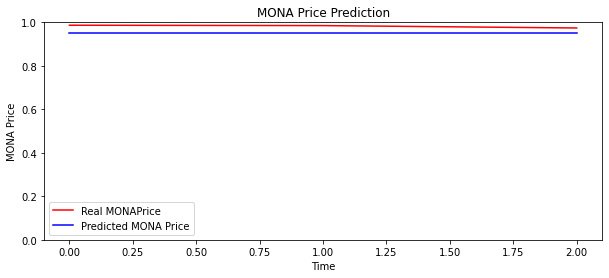

In [156]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real MONAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted MONA Price')
plt.title('MONA Price Prediction')
plt.xlabel('Time')
plt.ylabel('MONA Price')
plt.ylim(0,1)
plt.legend()
plt.show()